In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

%matplotlib inline

In [8]:
# параметры распределений
mu0, sigma0 = (-2., 3.), (1., 3.)
mu1, sigma1 = (3., 1.5), (2., 2)

In [9]:
def sample(d0, d1, n=32):
    x0 = d0.sample((n,))
    x1 = d1.sample((n,))
    y0 = torch.zeros((n, 1))
    y1 = torch.ones((n, 1))
    return torch.cat([x0, x1], 0), torch.cat([y0, y1], 0)

In [10]:
d0 = torch.distributions.Normal(torch.tensor(mu0), torch.tensor(sigma0))
d1 = torch.distributions.Normal(torch.tensor(mu1), torch.tensor(sigma1))

In [11]:
d0, d1

(Normal(loc: torch.Size([2]), scale: torch.Size([2])),
 Normal(loc: torch.Size([2]), scale: torch.Size([2])))

In [12]:
x, y = sample(d0, d1, 10)
x, y

(tensor([[-0.2253,  0.2419],
         [-1.3592, -0.3074],
         [-2.8295,  4.4561],
         [-2.7517, -0.6369],
         [-1.7182,  5.6996],
         [-0.9888,  3.3960],
         [-2.4488,  2.1543],
         [-3.9509,  7.7024],
         [-2.2895,  3.0829],
         [-1.7301,  2.2812],
         [ 0.8208,  1.9980],
         [ 2.9478, -1.7895],
         [ 4.2247,  3.7402],
         [ 2.1799,  2.2757],
         [-3.5314,  1.0445],
         [ 3.8198,  3.4018],
         [ 2.6249,  1.2622],
         [ 1.4640,  3.4025],
         [ 3.5071,  0.6887],
         [ 4.6225,  3.5643]]), tensor([[0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.]]))

In [14]:
x.size()

torch.Size([20, 2])

In [15]:
layer = nn.Linear(2, 1)
print([p.data[0] for p in layer.parameters()])
layer_opt = optim.SGD(lr=1e-3, params=list(layer.parameters()))

[tensor([ 0.1013, -0.1307]), tensor(0.4693)]


In [16]:
log_freq = 500
for i in range(10000):
    if i%log_freq == 0:
        with torch.no_grad():
            x, y = sample(d0, d1, 100000)
            out = torch.sigmoid(layer(x))
            loss = F.binary_cross_entropy(out, y)
        print('Ошибка после %d итераций: %f' %(i/log_freq, loss))
    layer_opt.zero_grad()
    x, y = sample(d0, d1, 1024)
    out = torch.sigmoid(layer(x))
    loss = F.binary_cross_entropy(out, y)
    loss.backward()
    layer_opt.step()

Ошибка после 0 итераций: 0.554639
Ошибка после 1 итераций: 0.324148
Ошибка после 2 итераций: 0.252813
Ошибка после 3 итераций: 0.217988
Ошибка после 4 итераций: 0.197002
Ошибка после 5 итераций: 0.184185
Ошибка после 6 итераций: 0.174280
Ошибка после 7 итераций: 0.166528
Ошибка после 8 итераций: 0.161129
Ошибка после 9 итераций: 0.158118
Ошибка после 10 итераций: 0.152924
Ошибка после 11 итераций: 0.150589
Ошибка после 12 итераций: 0.147879
Ошибка после 13 итераций: 0.145129
Ошибка после 14 итераций: 0.143118
Ошибка после 15 итераций: 0.141085
Ошибка после 16 итераций: 0.139659
Ошибка после 17 итераций: 0.138752
Ошибка после 18 итераций: 0.136906
Ошибка после 19 итераций: 0.136494


In [37]:
xy = np.mgrid[-10:10:1000j, -10:10:1000j]
xy

array([[[-10.        , -10.        , -10.        , ..., -10.        ,
         -10.        , -10.        ],
        [ -9.97997998,  -9.97997998,  -9.97997998, ...,  -9.97997998,
          -9.97997998,  -9.97997998],
        [ -9.95995996,  -9.95995996,  -9.95995996, ...,  -9.95995996,
          -9.95995996,  -9.95995996],
        ...,
        [  9.95995996,   9.95995996,   9.95995996, ...,   9.95995996,
           9.95995996,   9.95995996],
        [  9.97997998,   9.97997998,   9.97997998, ...,   9.97997998,
           9.97997998,   9.97997998],
        [ 10.        ,  10.        ,  10.        , ...,  10.        ,
          10.        ,  10.        ]],

       [[-10.        ,  -9.97997998,  -9.95995996, ...,   9.95995996,
           9.97997998,  10.        ],
        [-10.        ,  -9.97997998,  -9.95995996, ...,   9.95995996,
           9.97997998,  10.        ],
        [-10.        ,  -9.97997998,  -9.95995996, ...,   9.95995996,
           9.97997998,  10.        ],
        ...,


In [30]:
xy.shape

(1000000, 2)

In [38]:
x_scale = np.mgrid[-10:10:1000j, -10:10:1000j].reshape(2,-1).T
d0_pdf = stats.norm.pdf(x_scale, mu0, sigma0) 
d1_pdf = stats.norm.pdf(x_scale, mu1, sigma1)
x_tensor = torch.tensor(x_scale, dtype=torch.float)
with torch.no_grad():
    dist = torch.sigmoid(layer(x_tensor)).numpy()
ratio = d1_pdf / (d1_pdf + d0_pdf)

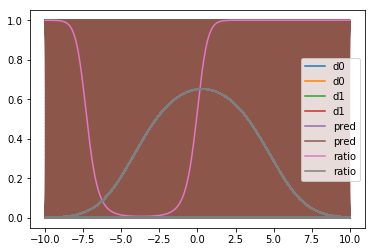

In [39]:
plt.plot(x_scale, d0_pdf*2, label='d0') # умножение на 2 для красоты графиков, на распределения не влияет
plt.plot(x_scale, d1_pdf*2, label='d1')
plt.plot(x_scale, dist.flatten(), label='pred')
plt.plot(x_scale, ratio, label='ratio')
plt.legend();

In [ ]:
print([p.data[0] for p in layer.parameters()])

In [ ]:
torch.log(F.sigmoid(torch.tensor(-100.)))

In [ ]:
F.logsigmoid(torch.tensor(-100.))